In [1]:
import os
os.chdir("../")
import pandas as pd
import numpy as np
import dask.dataframe as dd

import geopandas as gpd
import shapely
from shapely.geometry import Point, LineString

import folium
from folium import plugins

In [2]:
path = "/Users/czhang/Downloads/AIS_2022_01_01.csv"
ddf = dd.read_csv(path,
                  dtype={
                      'Length': 'float64',
                      'VesselType': 'float64',
                      'Width': 'float64'
                  })
ddf.head(5)

MMSI         BaseDateTime       LAT       LON  SOG    COG  Heading  \
0  368084090  2022-01-01T00:00:00  29.93174 -89.99243  6.0  296.2    299.0   
1  368140160  2022-01-01T00:00:00  30.33475 -87.14429  0.0  312.0     87.0   
2  366941830  2022-01-01T00:00:02  29.30919 -94.79702  0.0  180.2    511.0   
3  316005971  2022-01-01T00:00:06  46.50268 -84.35674  2.4  258.6    257.0   
4  316004054  2022-01-01T00:00:07  46.50326 -84.37506  0.3   61.9    511.0   

        VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  LARRY B WHIPPLE         NaN  WDK7401        57.0    12.0    23.0   10.0   
1    TWISTED ANGEL  IMO0000000  WDL5339        36.0     NaN    12.0    7.0   
2     SAN PATRICIO         NaN  WCX6675        31.0     5.0    18.0    7.0   
3      BEVERLY M I  IMO9084047  CFP2004        31.0     0.0    34.0   10.0   
4       ADANAC III  IMO8745333     VCLT        31.0     0.0    24.0    5.0   

   Draft  Cargo TransceiverClass  
0    3.0   57.0                A  
1    NaN    NaN                B  
2    NaN   57.0                A  
3    5.3   99.0                A  
4    3.0   50.0                A

In [3]:
sample_df = ddf[ddf.VesselType.isin([70,71,72])].compute()

In [4]:
sample_df = sample_df[sample_df.MMSI == 441486000]

In [5]:
sample_df = sample_df.reset_index().drop("index", axis=1)
sample_df["geometry"] = [Point(x, y) for x, y in zip(sample_df.LON, sample_df.LAT)]
gdf = gpd.GeoDataFrame(sample_df)

In [6]:
test_locs = [[b,a] for a, b in zip(gdf.LAT, gdf.LON)]
test_locs_re = [[a,b] for a, b in zip(gdf.LAT, gdf.LON)]
test_lst = []
for idx, val in enumerate(test_locs):
    test_dict = {}
    if idx < len(test_locs) -1:
        test_dict["coordinates"] = [val, test_locs[idx + 1]]
        test_dict["dates"] = [sample_df["BaseDateTime"][idx], sample_df["BaseDateTime"][idx+1]]
        test_dict["color"] = "red"
        test_lst.append(test_dict)

In [7]:
m = folium.plugins.DualMap([37.06237, -75.18991], zoom_start=3)
folium.plugins.AntPath(locations=test_locs_re,
                       reverse="True",
                       dash_array=[20, 30]).add_to(m.m1)
m.m1.fit_bounds(m.m1.get_bounds())


features = [{
    'type': 'Feature',
    'geometry': {
        'type': 'LineString',
        'coordinates': line['coordinates'],
    },
    'properties': {
        'times': line['dates'],
        'style': {
            'color': "blue",
            'weight': line['weight'] if 'weight' in line else 5
        }
    }
} for line in test_lst]

plugins.TimestampedGeoJson(
    {
        'type': 'FeatureCollection',
        'features': features,
    },
    period='PT1M',
    add_last_point=True).add_to(m.m2)

display(m)

## An Alternative

In [7]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import contextily as ctx

MovieWriter ffmpeg unavailable; using Pillow instead.


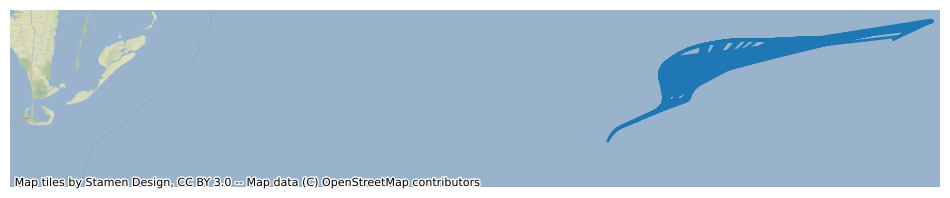

In [10]:
lat = np.array(sample_df["LAT"])
lon = np.array(sample_df["LON"])

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_ylim(37.00, 37.24)
ax.set_xlim(-76.00, -74.74)
ax.set_axis_off()
ctx.add_basemap(ax, crs="EPSG:4326")
line, = ax.plot(lon, lat, lw=2)


def animate(n, lat, lon, line):
    line.set_data(lon[:n], lat[:n])
    return line,


anim = animation.FuncAnimation(fig, animate, len(lat), fargs=(lat, lon, line) , interval=20, blit=True)
anim.save('output/basic_animation.gif')